In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import liana as li

In [2]:
import muon as mu
import plotnine as p9
import mofax as mofa

/home/dbdimitrov/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
INVERSE_FUN = lambda x: -np.log10(x)
groupby = 'cell_type_original' # NOTE: the same cell types but readable
sample_key = 'sample'
condition_key = 'patient_group'

In [35]:
resource = pd.read_csv(os.path.join('results', 'lr_pairs.csv'))
cell_pairs = pd.read_csv(os.path.join('results', 'cell_pairs.csv'))

Run LIANA + MOFA

In [5]:
adata = sc.read_h5ad(os.path.join('results', 'kuppe_processed.h5ad'))

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [6]:
mdata = li.multi.lrs_to_views(adata,
                              score_key='magnitude_rank',
                              inverse_fun=INVERSE_FUN,
                              obs_keys=[condition_key], # add those to mdata.obs
                              lr_prop = 0.3, # minimum required proportion of samples to keep an LR
                              lrs_per_sample = 15, # minimum number of interactions to keep a sample in a specific view
                              lrs_per_view = 20, # minimum number of interactions to keep a view
                              samples_per_view = 10, # minimum number of samples to keep a view
                              min_variance = 0, # minimum variance to keep an interaction
                              lr_fill = 0, # fill missing LR values across samples with this
                              verbose=True
                              )

100%|██████████| 40/40 [00:00<00:00, 161.31it/s]


In [7]:
outfile = os.path.join('results', 'models', 'mofatalk.h5ad')

In [8]:
model = mu.tl.mofa(mdata,
                   use_obs='union',
                   outfile=outfile,
                   seed=1337,
                   n_factors=10,
                   convergence_mode='slow',
                   scale_views=True,
                #    copy=True
                )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Loaded view='Cardiomyocyte&Cardiomyocyte' group='group1' with N=28 samples and D=230 features...
Loaded view='Lymphoid&Cardiomyocyte' group='group1' with N=28 samples and D=170 features...
Loaded view='Endothelial&Cardiomyocyte' group='group1' with N=28 samples and D=225 features...
Loaded view='Neuronal&Cardiomyocyte' group='group1' with N=28 

In [9]:
# obtain factor scores
factor_scores = li.ut.get_factor_scores(mdata, obsm_key='X_mofa', obs_keys=condition_key)
factor_scores.head()

,sample,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,patient_group
0,CK158,-2.666372,0.208225,-0.137331,-0.645521,0.013322,-0.060797,-0.064427,-0.071403,-0.024400,-0.029169,myogenic
1,CK159,-0.072433,0.738352,-0.304622,-0.184614,-0.247584,-0.071177,-0.089014,-0.083601,-0.094884,-0.049771,myogenic
2,CK160,0.257646,-0.383103,-0.360152,0.105625,0.701161,-0.104135,-0.046816,-0.103637,-0.010168,-0.039995,myogenic
3,CK162,0.575947,0.508319,-0.288252,-0.807658,-0.180584,-0.091087,-0.079098,-0.050479,1.695546,-0.052568,fibrotic
4,CK163,-1.234322,0.623385,-0.446480,-0.565488,-0.122620,-0.089944,-0.076606,-0.070652,-0.046439,-0.027675,myogenic


In [10]:
model = mofa.mofa_model(outfile)
model

MOFA+ model: mofatalk.h5ad
Samples (cells): 28
Features: 6818
Groups: group1 (28)
Views: Adipocyte&Adipocyte (65), Adipocyte&Endothelial (96), Adipocyte&Fibroblast (116), Adipocyte&Vascular_SMCs (97), Cardiomyocyte&Cardiomyocyte (230), Cardiomyocyte&Endothelial (169), Cardiomyocyte&Lymphoid (147), Cardiomyocyte&Neuronal (183), Cardiomyocyte&Pericyte (172), Endothelial&Adipocyte (80), Endothelial&Cardiomyocyte (225), Endothelial&Endothelial (165), Endothelial&Fibroblast (196), Endothelial&Pericyte (169), Endothelial&Vascular_SMCs (226), Fibroblast&Adipocyte (101), Fibroblast&Endothelial (192), Fibroblast&Fibroblast (236), Fibroblast&Mast (225), Fibroblast&Myeloid (211), Fibroblast&Neuronal (214), Fibroblast&Vascular_SMCs (270), Lymphoid&Cardiomyocyte (170), Lymphoid&Lymphoid (107), Lymphoid&Myeloid (128), Mast&Fibroblast (151), Mast&Mast (136), Myeloid&Fibroblast (162), Myeloid&Lymphoid (127), Myeloid&Myeloid (164), Neuronal&Cardiomyocyte (226), Neuronal&Fibroblast (201), Neuronal&Neuro

Explore Results

In [11]:
factor_of_interest = "Factor1"

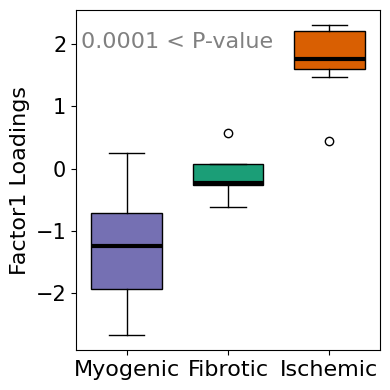

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway

# Assuming factor_scores is your DataFrame and condition_key is the column for conditions
factor_scores[condition_key] = factor_scores[condition_key].str.title().astype('category')
labels = ['Myogenic', 'Fibrotic', 'Ischemic']

# Set the color palette and style
colors = ['#7570b3', '#1b9e77', '#d95f02']

# Create a boxplot
plt.figure(figsize=(4, 4))
box_positions = np.arange(1, len(labels) + 1)

for i, label in enumerate(labels):
    subset = factor_scores[factor_scores[condition_key] == label][factor_of_interest]
    plt.boxplot(subset, positions=[box_positions[i]], widths=0.7, patch_artist=True, boxprops=dict(facecolor=colors[i]), medianprops=dict(color='black', linewidth=3))

# Perform one-way ANOVA
groups = [factor_scores[factor_scores[condition_key] == group][factor_of_interest] for group in labels]
statistic, p_value = f_oneway(*groups)

pval = round(p_value, 3)
plt.text(1.5, max([group.min() for group in groups]) + 1.5, f'{pval+ 0.0001:.4f} < P-value', ha='center', fontsize=16, color='grey')

# Set labels and title
plt.xlabel('')
plt.ylabel(f'{factor_of_interest} Loadings', fontsize=16)
plt.title('')
plt.xticks(box_positions, labels, fontsize=16) 
plt.yticks(fontsize=15)
plt.tight_layout()

# Show the plot
plt.show()


In [13]:
variable_loadings =  li.ut.get_variable_loadings(mdata,
                                                 varm_key='LFs',
                                                 view_sep=':',
                                                 pair_sep="&",
                                                 variable_sep="^") # get loadings for factor 1
variable_loadings.head()

# here we will just assign the size of the dots, but this can be replace by any other statistic
variable_loadings['size'] = 4.5



In [14]:
variable_loadings.to_csv(os.path.join('results', 'kuppe_mofa_loadings.csv'))

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


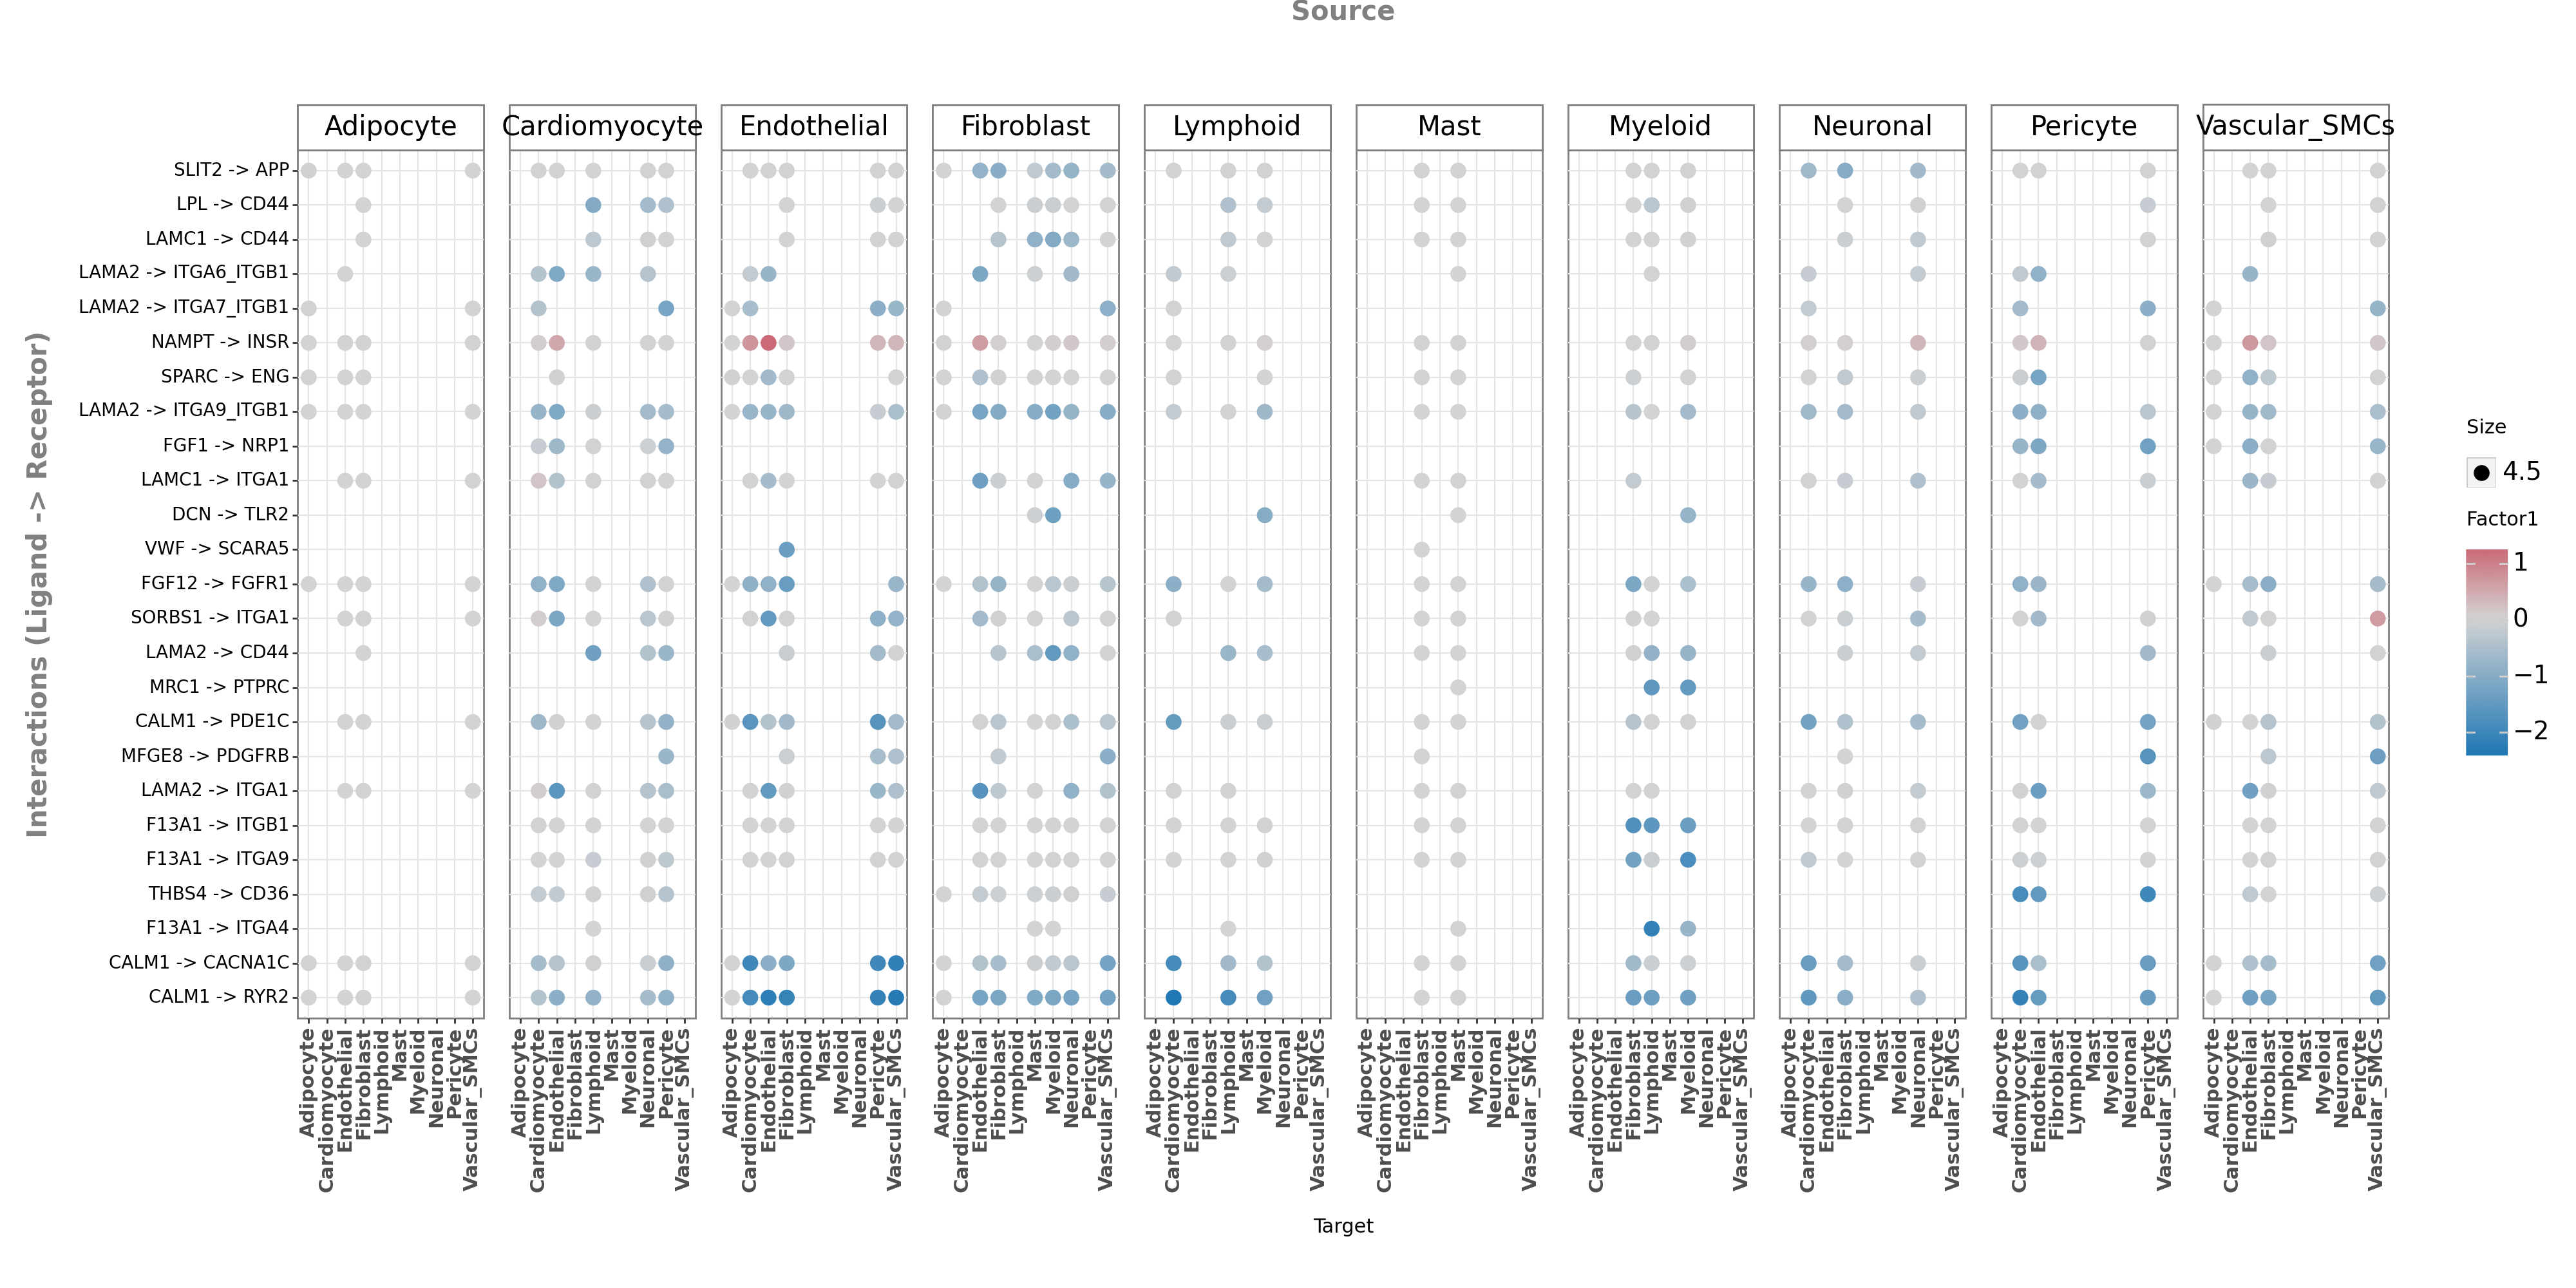

<Figure Size: (2000 x 1000)>

In [15]:
my_plot = li.pl.dotplot(liana_res = variable_loadings,
                        size='size',
                        colour=factor_of_interest,
                        orderby=factor_of_interest,
                        top_n=25,
                        orderby_absolute=True,
                        orderby_ascending=False,
                        size_range=(0.1, 4),
                        figure_size=(20, 10)
                        )
# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0)

In [16]:
# import omnipath as op
# inter = op.interactions.import_intercell_network()

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


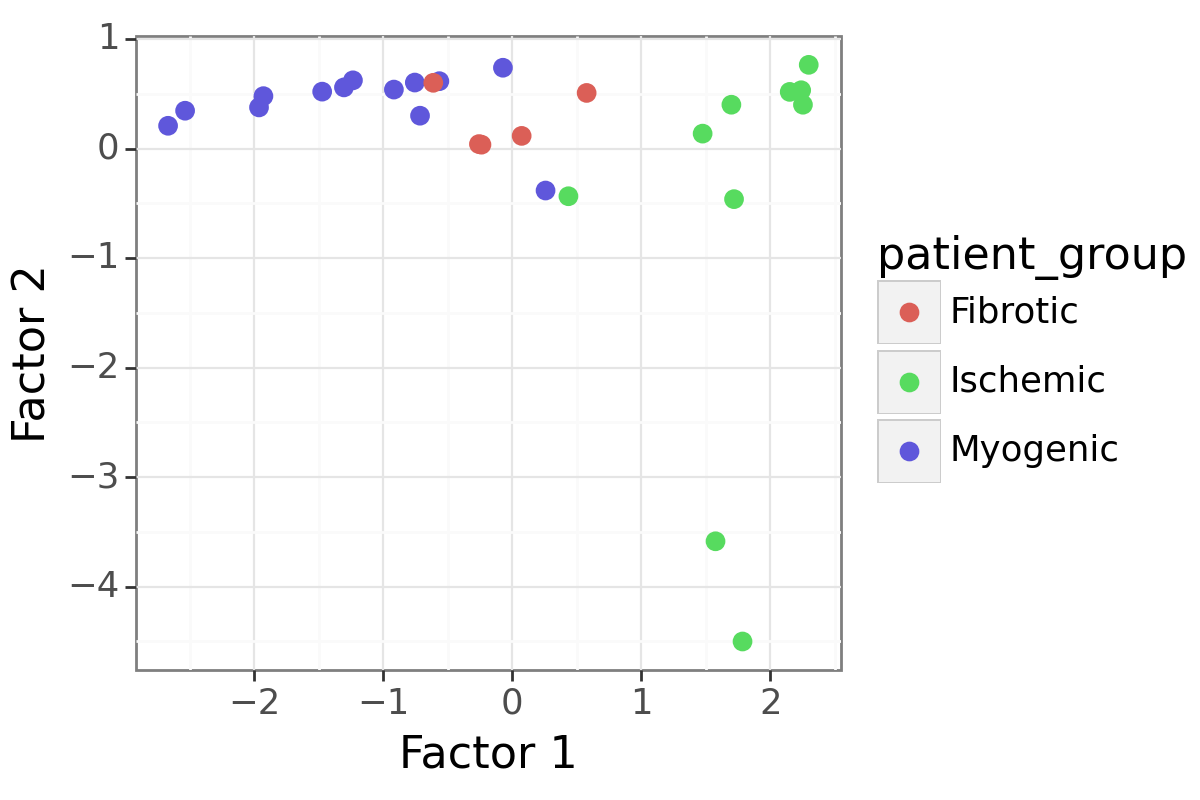

<Figure Size: (600 x 400)>

In [17]:
# dotplot of Factor1 (x) and Factor2 (y)
(
    p9.ggplot(factor_scores) +
    p9.aes(x='Factor1', y='Factor2', colour=condition_key) +
    p9.geom_point(size=3) +
    p9.theme_bw(base_size=16) +
    p9.theme(figure_size=(6, 4)) +
    p9.labs(x='Factor 1', y='Factor 2')
)

Factor 1 R2 per view

In [18]:
# get variance explained by view and factor
rsq = model.get_r2()
factor_rsq = rsq[rsq['Factor']==factor_of_interest]
# separate view column
factor_rsq[['source', 'target']] = factor_rsq['View'].str.split('&', 1, expand=True)

In [19]:
factor_rsq['source'] = factor_rsq['source'].astype('category')
factor_rsq['target'] = factor_rsq['target'].astype('category')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


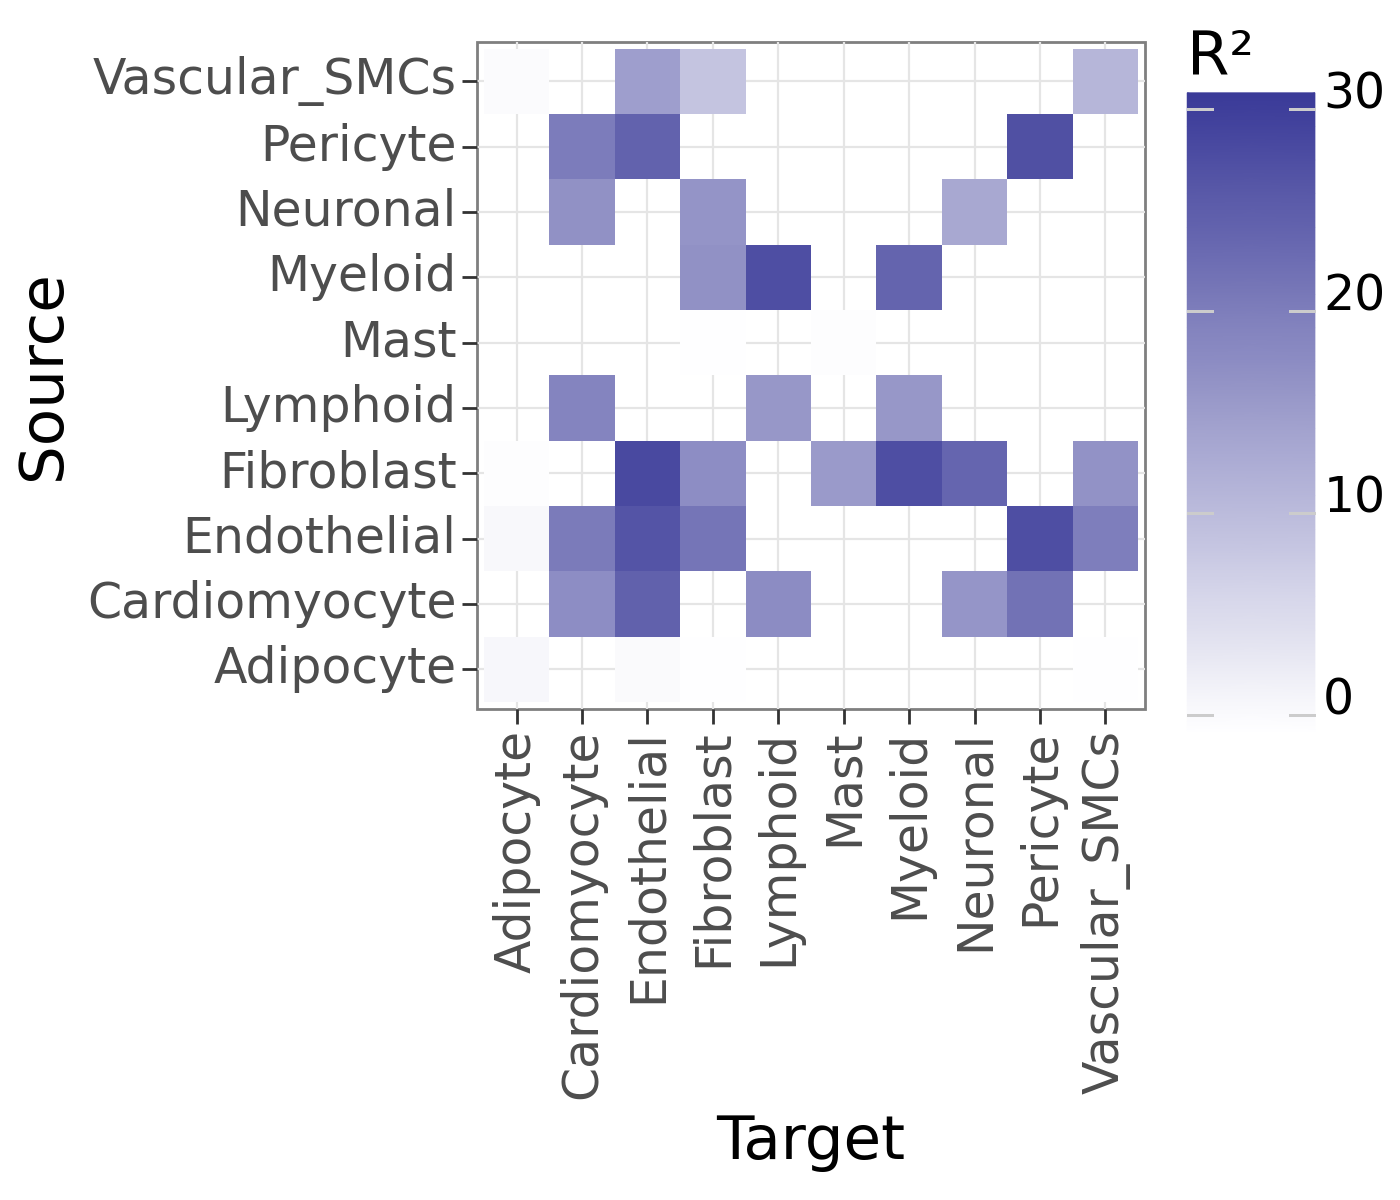

<Figure Size: (700 x 600)>

In [20]:
(p9.ggplot(factor_rsq.reset_index()) +
 p9.aes(x='target', y='source') +
 p9.geom_tile(p9.aes(fill='R2')) +
#  p9.scale_fill_gradient2(low='white', high='#c20019') +
# limits 
    p9.scale_fill_gradient2(limits=(0, 30)) +
 p9.theme_bw(base_size=22) +
 p9.labs(x='Target', y='Source', fill='R²') +
 p9.theme(axis_text_x=p9.element_text(rotation=90), figure_size=(7,6))
)

In [21]:
variable_loadings.sort_values(by="Factor1", ascending=False, key=abs).head()

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size
256,CALM1,RYR2,Lymphoid,Cardiomyocyte,-2.322011,0.031999,-0.000043,-0.012426,0.038067,0.113312,0.536409,-0.001623,0.070467,-0.022502,4.5
3124,CALM1,RYR2,Endothelial,Vascular_SMCs,-2.210037,0.014851,-0.064957,0.001833,-0.007645,0.215949,-0.036093,0.004170,-0.032987,-0.374228,4.5
4244,CALM1,RYR2,Endothelial,Endothelial,-2.130499,0.030715,-0.162850,0.004328,0.014155,0.129944,-0.067511,0.035033,-0.391927,-0.122780,4.5
3119,CALM1,CACNA1C,Endothelial,Vascular_SMCs,-2.070948,0.020283,0.008218,-0.011909,0.180657,0.014911,0.012785,0.001108,1.311637,-0.447014,4.5
1910,CALM1,RYR2,Pericyte,Cardiomyocyte,-2.058841,-0.002065,0.027452,0.031494,0.091225,0.192298,-0.145476,0.000840,-0.184058,0.509759,4.5


In [22]:
ct_int = variable_loadings[(variable_loadings['source']=='Cardiomyocyte') & (variable_loadings['target']=='Endothelial')]

In [23]:
# rank by absolute values of Factor 1
ct_int['rank'] = ct_int['Factor1'].rank(ascending=False)

In [65]:
ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(5)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
1263,LAMA2,ITGA1,Cardiomyocyte,Endothelial,-1.549723,0.056588,0.041614,0.013378,-0.019812,0.037531,-0.057331,0.049195,0.016652,-0.029994,1.549723,169.0,
1304,SORBS1,ITGA1,Cardiomyocyte,Endothelial,-1.107675,0.011778,0.059180,0.000525,-0.074886,-0.010883,0.004869,0.007940,0.020756,-0.070191,1.107675,168.0,
1264,LAMA2,ITGA6_ITGB1,Cardiomyocyte,Endothelial,-1.083553,-0.023843,0.168254,0.015601,0.020893,0.180252,0.117355,0.001413,0.003358,0.081474,1.083553,167.0,LAMA2 -> ITGA6_ITGB1
1265,LAMA2,ITGA9_ITGB1,Cardiomyocyte,Endothelial,-1.080487,-0.011025,0.159444,0.019122,0.019677,0.156390,0.064955,0.000638,0.003201,0.144150,1.080487,166.0,
1247,FGF12,FGFR1,Cardiomyocyte,Endothelial,-1.055180,-0.010990,0.009556,0.002038,-0.103200,-0.002051,-0.038579,-0.007929,0.002630,0.019443,1.055180,165.0,


In [25]:

ct_int['name'] = ct_int['ligand_complex'] + ' -> ' + ct_int['receptor_complex']
# # keep name for only the top 5 by absolute values of Factor 1
# ct_names = ct_int.sort_values(by='Factor1', ascending=False, key=abs).head(1)['name'].tolist()
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_names else '')
# keep top 1 according to rank
# ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int.sort_values(by='rank', ascending=True).head(1)['name'].tolist() else '')
## keep name where ligand_complex=="LAMA2" and receptor_complex=="ITGA6_ITGB1" (top 3)
ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['ligand_complex']=="LAMA2"]['name'].tolist() else '')
ct_int['name'] = ct_int['name'].apply(lambda x: x if x in ct_int[ct_int['receptor_complex']=="ITGA6_ITGB1"]['name'].tolist() else '')

In [26]:
ct_int.sort_values("Factor1")

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
1263,LAMA2,ITGA1,Cardiomyocyte,Endothelial,-1.549723,0.056588,0.041614,0.013378,-0.019812,0.037531,-0.057331,0.049195,0.016652,-0.029994,4.5,169.0,
1304,SORBS1,ITGA1,Cardiomyocyte,Endothelial,-1.107675,0.011778,0.059180,0.000525,-0.074886,-0.010883,0.004869,0.007940,0.020756,-0.070191,4.5,168.0,
1264,LAMA2,ITGA6_ITGB1,Cardiomyocyte,Endothelial,-1.083553,-0.023843,0.168254,0.015601,0.020893,0.180252,0.117355,0.001413,0.003358,0.081474,4.5,167.0,LAMA2 -> ITGA6_ITGB1
1265,LAMA2,ITGA9_ITGB1,Cardiomyocyte,Endothelial,-1.080487,-0.011025,0.159444,0.019122,0.019677,0.156390,0.064955,0.000638,0.003201,0.144150,4.5,166.0,
1247,FGF12,FGFR1,Cardiomyocyte,Endothelial,-1.055180,-0.010990,0.009556,0.002038,-0.103200,-0.002051,-0.038579,-0.007929,0.002630,0.019443,4.5,165.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,COL6A1,ITGA9_ITGB1,Cardiomyocyte,Endothelial,0.126013,-0.000051,0.012118,-0.012178,0.004115,-0.006726,-0.026600,0.004227,-0.006630,-0.049368,4.5,5.0,
1232,COL6A1,ITGA1_ITGB1,Cardiomyocyte,Endothelial,0.151419,0.001713,0.001178,-0.007949,0.004437,-0.014129,-0.030287,0.004403,-0.006922,-0.002302,4.5,4.0,
1322,THBS1,PTPRJ,Cardiomyocyte,Endothelial,0.157522,-0.001207,0.066181,-0.006489,0.467672,-0.016638,-0.000493,-0.000484,-0.007657,1.129760,4.5,3.0,
1193,CALM1,INSR,Cardiomyocyte,Endothelial,0.232656,0.016301,0.022321,-0.005150,-0.026816,0.069857,-0.019656,-0.004758,-0.002490,-0.047534,4.5,2.0,


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


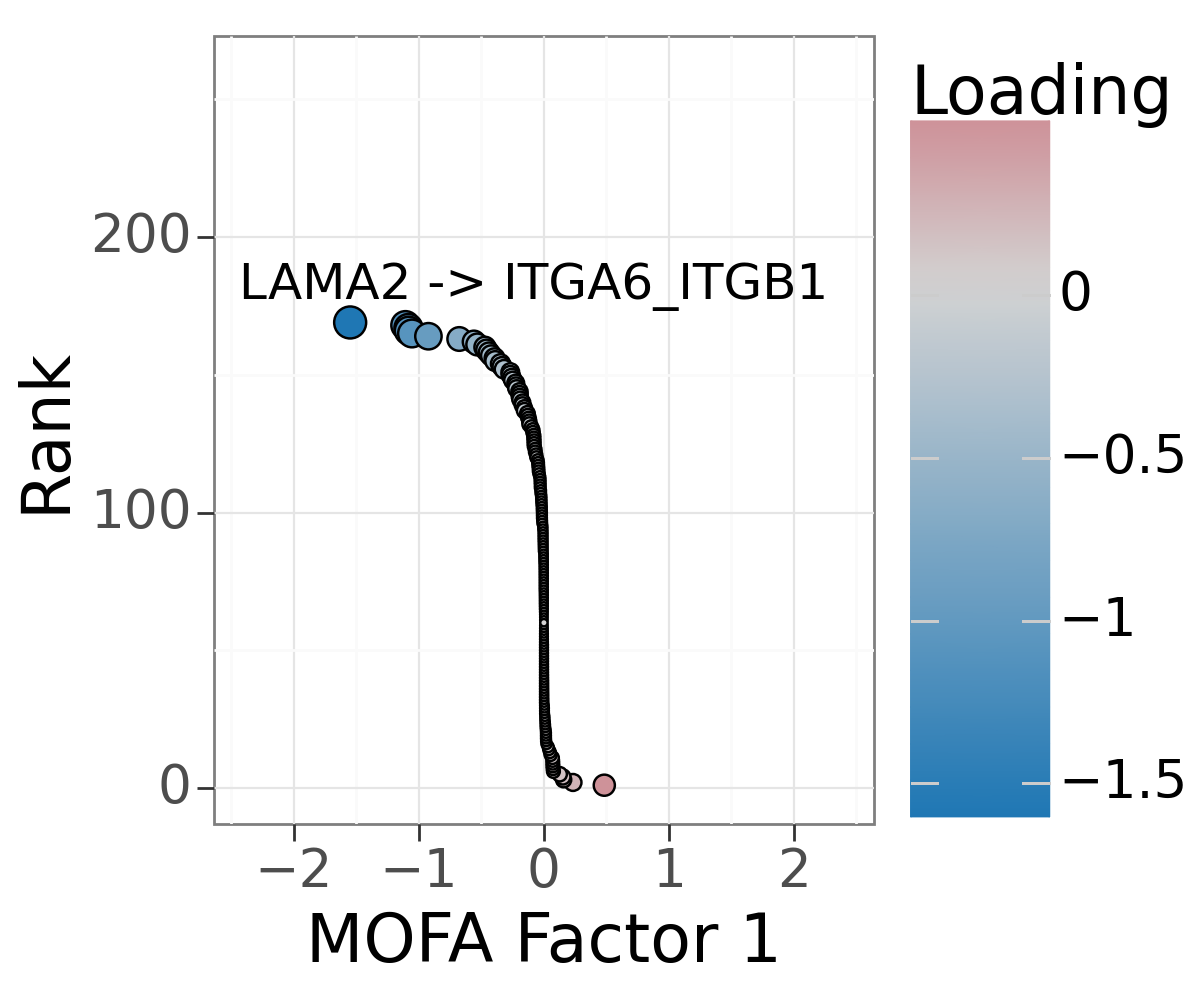

<Figure Size: (600 x 500)>

In [27]:
ct_int['size'] = ct_int['Factor1'].abs()
(
    p9.ggplot(ct_int) +
    p9.aes(x='Factor1', y='rank', fill='Factor1', size='size') +
    p9.geom_point() +
    p9.geom_text(p9.aes(label='name'), size=18, nudge_x=1, nudge_y=15) +
    p9.theme_bw(base_size=24) +
    p9.theme(figure_size=(6, 5)) +
    p9.scale_x_continuous(limits=(-2.4, 2.4)) +
    # scale rank to 0-200
    p9.scale_y_continuous(limits=(0, 260)) +
    p9.scale_fill_gradient2(low='#1f77b4', mid='lightgray', high='#c20019', midpoint=0) +
    p9.labs(x='MOFA Factor 1', y='Rank', fill='Loading') +
    # hide size
    p9.guides(size=False)
)

In [28]:
ct_int.sort_values("Factor1", key=abs, ascending=False)

,ligand_complex,receptor_complex,source,target,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,size,rank,name
1263,LAMA2,ITGA1,Cardiomyocyte,Endothelial,-1.549723,0.056588,0.041614,0.013378,-0.019812,0.037531,-0.057331,0.049195,0.016652,-0.029994,1.549723,169.0,
1304,SORBS1,ITGA1,Cardiomyocyte,Endothelial,-1.107675,0.011778,0.059180,0.000525,-0.074886,-0.010883,0.004869,0.007940,0.020756,-0.070191,1.107675,168.0,
1264,LAMA2,ITGA6_ITGB1,Cardiomyocyte,Endothelial,-1.083553,-0.023843,0.168254,0.015601,0.020893,0.180252,0.117355,0.001413,0.003358,0.081474,1.083553,167.0,LAMA2 -> ITGA6_ITGB1
1265,LAMA2,ITGA9_ITGB1,Cardiomyocyte,Endothelial,-1.080487,-0.011025,0.159444,0.019122,0.019677,0.156390,0.064955,0.000638,0.003201,0.144150,1.080487,166.0,
1247,FGF12,FGFR1,Cardiomyocyte,Endothelial,-1.055180,-0.010990,0.009556,0.002038,-0.103200,-0.002051,-0.038579,-0.007929,0.002630,0.019443,1.055180,165.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,COL4A1,ITGA1_ITGB1,Cardiomyocyte,Endothelial,-0.000109,0.001422,0.115354,0.045440,0.405012,0.095413,1.521922,-0.018521,0.012909,0.006699,0.000109,63.0,
1336,VWF,ITGA9,Cardiomyocyte,Endothelial,-0.000065,-0.009701,0.148209,-0.001998,-0.012149,-0.006854,-0.004547,-0.002330,0.036160,0.013608,0.000065,62.0,
1239,COL8A1,ITGA1_ITGB1,Cardiomyocyte,Endothelial,0.000054,0.000401,0.292765,0.000044,-0.000312,0.358704,-0.001723,-0.000187,0.000209,0.000368,0.000054,59.0,
1287,MFGE8,ITGB5,Cardiomyocyte,Endothelial,-0.000046,0.000031,0.006705,0.000074,-0.000103,-0.000109,-0.000032,-0.000082,-0.000063,0.004910,0.000046,61.0,


PyDESeq2

In [29]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc
# import omnipath as op

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

from matplotlib import pyplot as plt


AnnData

In [30]:
adata = sc.read_h5ad(os.path.join('results', 'kuppe_processed.h5ad'))

Create Pseudobulk

In [32]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)
pdata

AnnData object with n_obs × n_vars = 273 × 26972
    obs: 'sample', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells'
    layers: 'psbulk_props'

In [33]:
pdata.obs = pdata.obs[[sample_key, groupby, condition_key, "patient_region_id", "major_labl", "cell_type", "psbulk_n_cells", "psbulk_counts"]]

In [37]:
pdata.write_h5ad(os.path.join('results', 'kuppe_pseudobulk.h5ad'))

Normalize

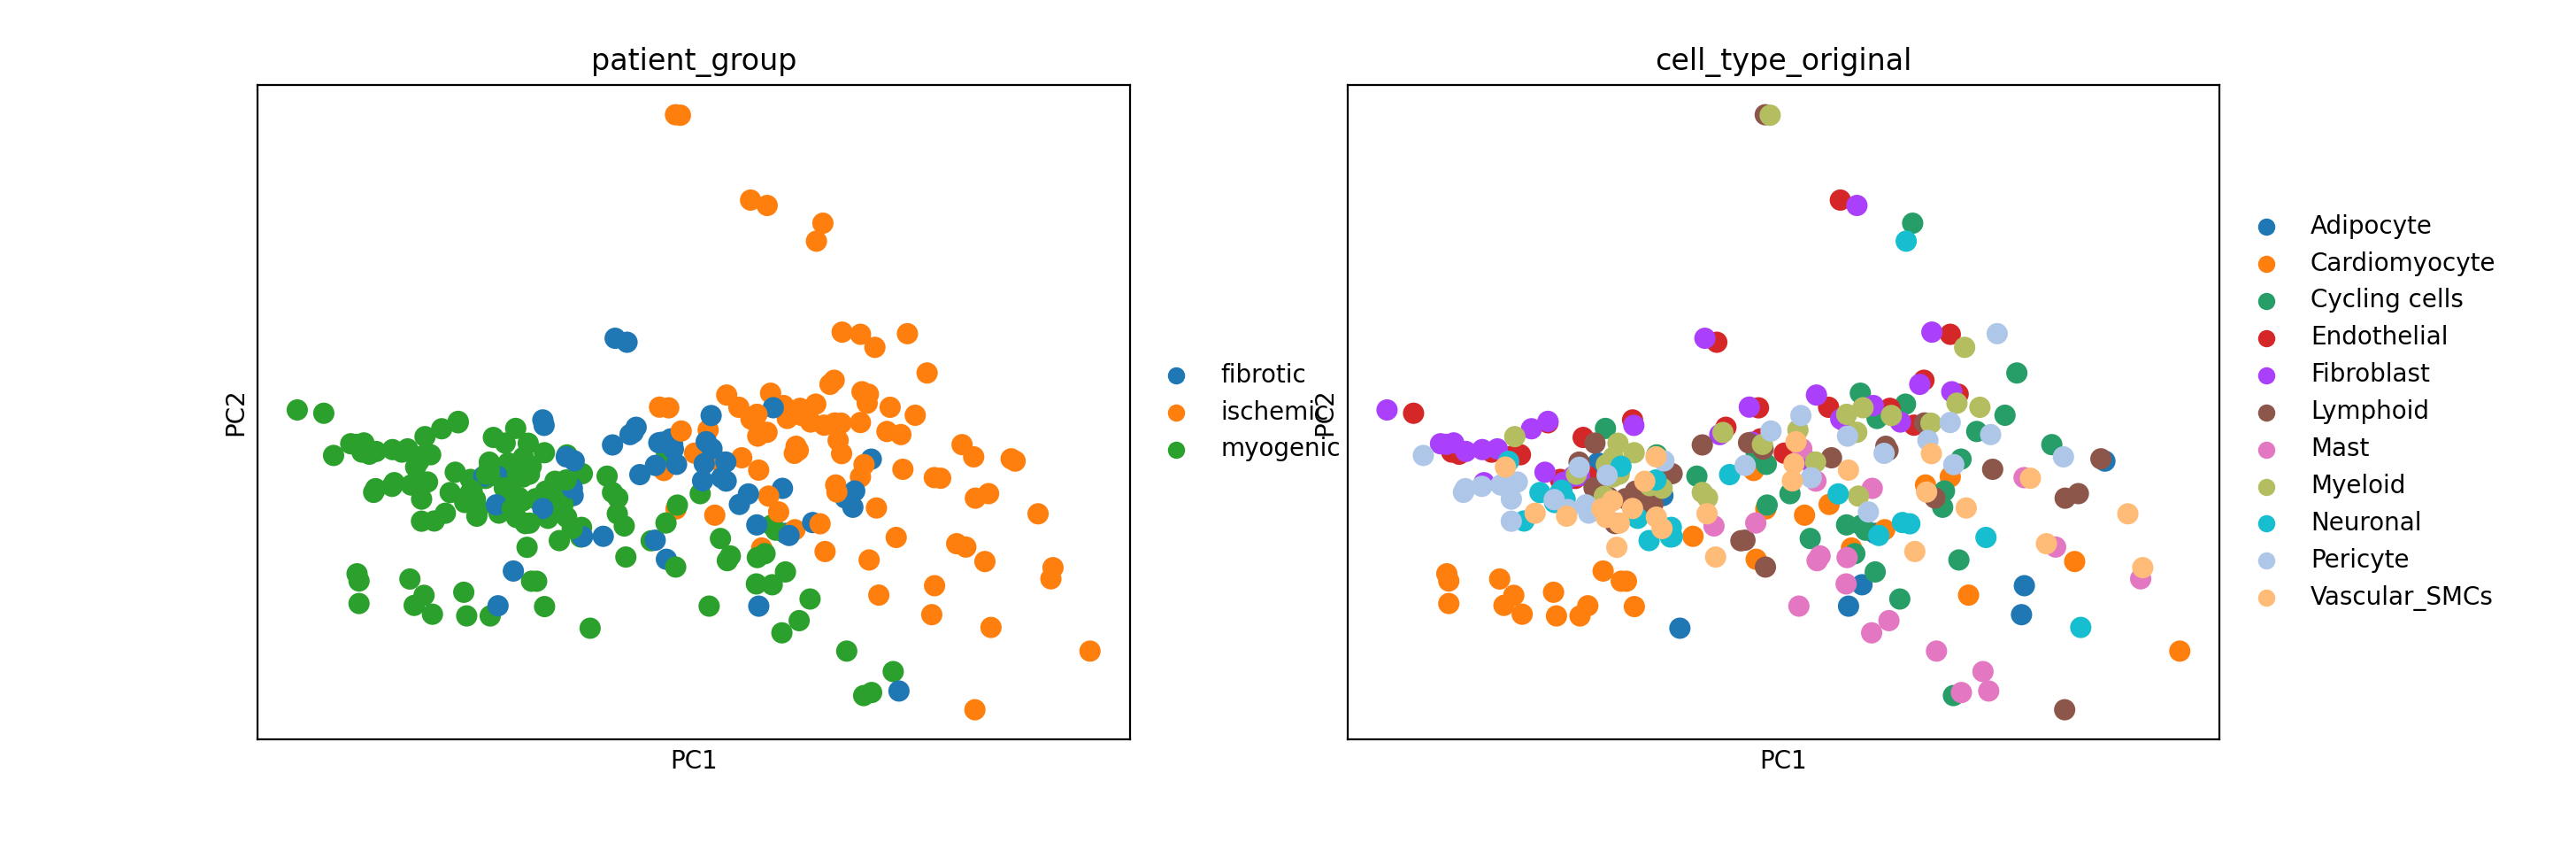

In [38]:
pp_pdata = pdata.copy()
sc.pp.normalize_total(pp_pdata, target_sum=1e6)
sc.pp.log1p(pp_pdata)
sc.pp.scale(pp_pdata, max_value=10)
sc.tl.pca(pp_pdata, n_comps=10)

sc.pl.pca(pp_pdata, color=[condition_key, groupby], ncols=2, show=True, size=300)

In [39]:
dc.get_metadata_associations(
    pp_pdata,
    obs_keys = [groupby, condition_key], #metadata columns to associate to PCs
    obsm_key='X_pca',  # where the PCs are stored
    uns_key='pca_anova',  # where the results are stored
    inplace=True
)



100%|██████████| 10/10 [00:00<00:00, 106.67it/s]


Starting plotting HeatmapAnnotations
Estimated legend width: 44.275 mm


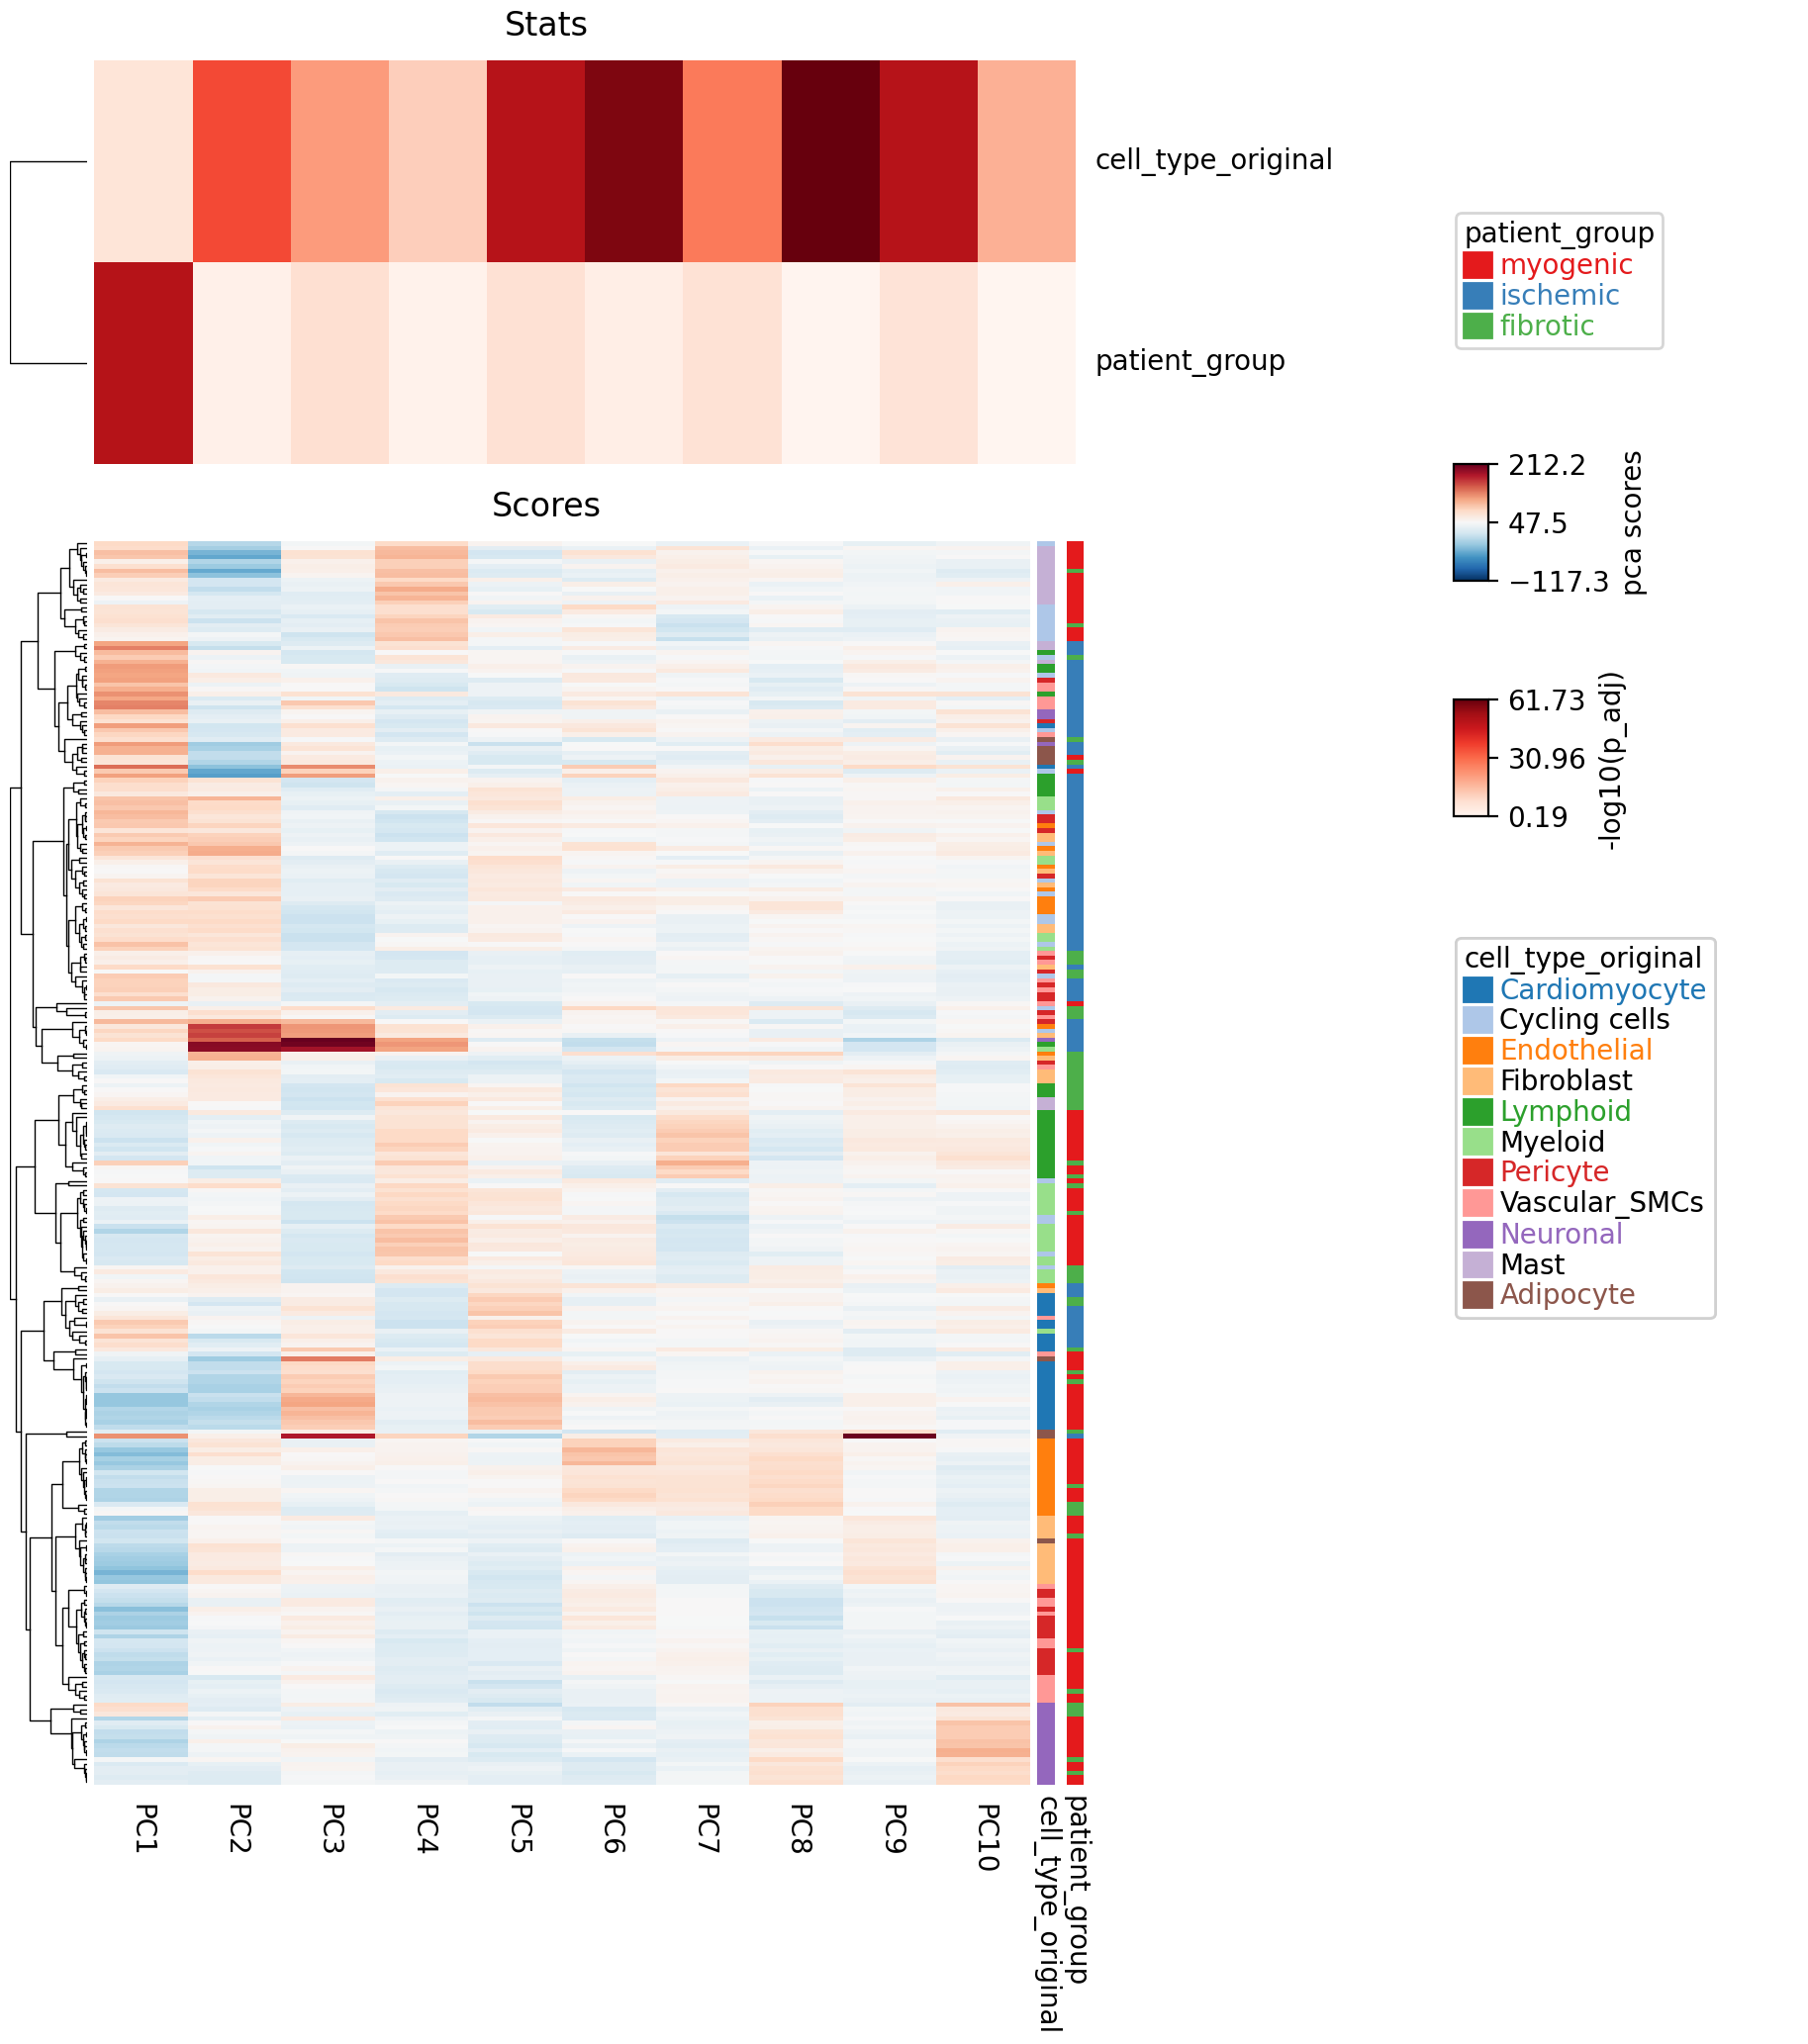

In [40]:
plt.figure(figsize=(7,10))
ax, legend_axes = dc.plot_associations(
    pp_pdata,
    uns_key='pca_anova',  # summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # which summary statistic to plot
    obs_annotation_cols = [groupby, condition_key], # which sample annotations to plot
)
plt.show()

In [41]:
pdata.obs['condition'] = 'Rest'
pdata.obs.loc[pdata.obs[condition_key]=='ischemic', 'condition'] = 'IZ'

In [42]:
condition_key = 'condition'
ref = "Rest"
cond = "IZ"

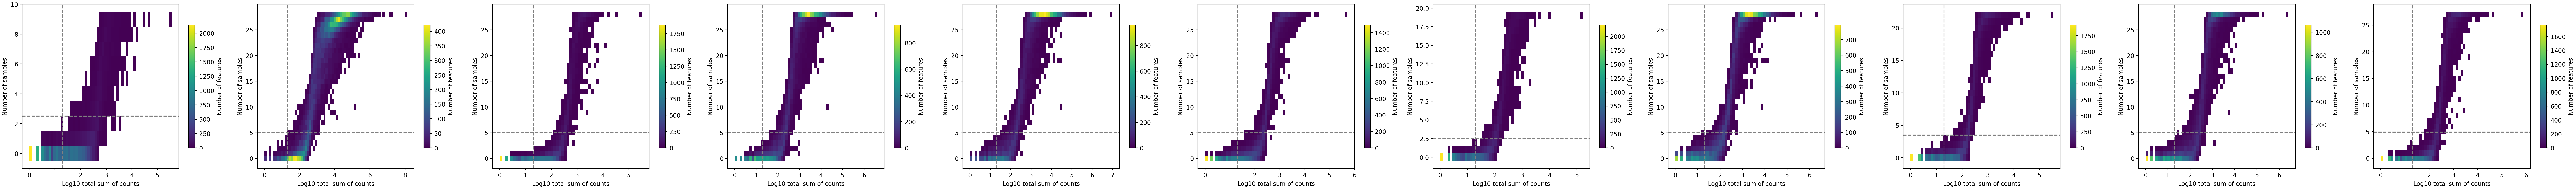

In [43]:
min_count = 10
min_total_count = 20
large_n = 5
min_prop = 0.1

# plt with ax with same number as groups
fig, axes = plt.subplots(1, len(pdata.obs[groupby].unique()), figsize=(7*len(pdata.obs[groupby].unique()), 5))

for i, cell_group in enumerate(pdata.obs[groupby].unique()):
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    dc.plot_filter_by_expr(ctdata, group=condition_key, min_count=min_count, min_total_count=min_total_count, large_n=large_n, min_prop=min_prop, ax =axes[i])

In [44]:
%%capture
dea_results = {}

for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()
    dc.plot_filter_by_expr(ctdata, group=condition_key, min_count=min_count, min_total_count=min_total_count, large_n=large_n)

    # Obtain genes that pass the edgeR-like thresholds
    # NOTE: QC thresholds might differ between cell types, consider applying them by cell type
    genes = dc.filter_by_expr(ctdata,
                              group=condition_key,
                              min_count=min_count,
                              min_total_count=min_total_count,
                              large_n=large_n,
                              min_prop=min_prop
                              )

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()

    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'Rest'],
        refit_cooks=True,
    )

    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, cond, ref])
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff=f'{condition_key}_{cond}_vs_{ref}') # {condition_key}_cond_vs_ref

    dea_results[cell_group] = stat_res.results_df

In [45]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby})
dea_df.set_index('feature_name', inplace=True)
dea_df.to_csv(os.path.join('results', 'dea.csv'))

In [46]:
dea_df.head()

,cell_type_original,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
feature_name,,,,,,,
AACS,Adipocyte,14.042497,-0.109025,0.333574,-2.115868,0.034356,0.391002
AAK1,Adipocyte,28.884569,-0.013459,0.310248,-0.131335,0.895510,0.973433
AASS,Adipocyte,31.960581,-0.065558,0.325075,-1.065659,0.286578,0.743675
ABCA1,Adipocyte,28.841675,0.022765,0.332872,0.253995,0.799500,0.961841
ABCA5,Adipocyte,14.516484,-0.084124,0.327101,-0.971239,0.331429,0.767008


Read DEA Results

In [47]:
dea_df = pd.read_csv(os.path.join('results', 'dea.csv'), index_col=0)

In [48]:
# keep only iz
adata_s = adata[adata.obs['patient_group']=='ischemic', :] # change to condition key when in adata

In [49]:
adata_s.X = adata_s.layers['counts'].copy()

In [50]:
sc.pp.normalize_total(adata_s)
sc.pp.log1p(adata_s)
# NOTE: it's not already log-transformed (its something with the way it's saved)

In [51]:
lr_res = li.multi.df_to_lr(adata_s,
                           dea_df=dea_df,
                           resource=resource,
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'padj'],
                           use_raw=False,
                           complex_col='stat', # NOTE: we use the Wald Stat to deal with complexes
                           verbose=True,
                           return_all_lrs=False,
                           groupby_pairs=cell_pairs,
                           )

Using `.X`!
3906 features of mat are empty, they will be removed.


Using provided `resource`.


['RMRP_ENSG00000269900', 'ALG1L9P_ENSG00000248671', 'RP11-436O19__A.6', 'LINC01830_ENSG00000234207', 'LINC00486_ENSG00000230876', 'SLFN12L_ENSG00000205045', 'POLR2J3_ENSG00000285437', 'SIGLEC5_ENSG00000105501', 'DNAJC9-AS1_ENSG00000227540', 'ITFG2-AS1_ENSG00000258325', 'FAM153B_ENSG00000182230', 'RAET1E-AS1_ENSG00000268592', 'PINX1_ENSG00000254093', 'ELFN2_ENSG00000243902', 'SPATA13_ENSG00000182957', 'DUXAP8_ENSG00000206195', 'DGCR5_ENSG00000273032', 'RP4-633O19__A.1', 'LINC00941_ENSG00000285517', 'DNAJC9-AS1_ENSG00000236756', 'LINC00486_ENSG00000236854', 'RNU11_ENSG00000270103', 'CLCA4-AS1_ENSG00000236915', 'RP11-99J16__A.2', 'LINC01115_ENSG00000237667', 'LINC01605_ENSG00000253161', 'XXyac-YX65C7_A.2', 'LINC01830_ENSG00000228999', 'RPPH1_ENSG00000259001', 'PRICKLE2-AS1_ENSG00000241111', 'RP1-213J1P__B.1', 'CCDC39_ENSG00000284862', 'SCARNA2_ENSG00000270066', 'RGS5_ENSG00000232995', 'RP11-1157N2__B.2', 'RNU12_ENSG00000270022', 'RGS5_ENSG00000143248', 'PROX1-AS1_ENSG00000230461', 'PDE11A

In [54]:
lr_res[lr_res['ligand_complex'].str.contains('LAMA')].drop('interaction', axis=1).sort_values("interaction_stat").head(20)

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_stat,ligand_padj,ligand_expr,ligand_props,target,receptor_stat,receptor_padj,receptor_expr,receptor_props,interaction_stat,interaction_padj,interaction_expr,interaction_props
4622,LAMA2,ITGA1,LAMA2,ITGA1,Fibroblast,-7.715340,3.873842e-13,1.032447,0.798655,Endothelial,-5.595170,1.665920e-07,0.201407,0.241895,-6.655255,8.329620e-08,0.616927,0.520275
1122,LAMA2,ITGA1,LAMA2,ITGA1,Cardiomyocyte,-7.284612,1.744948e-11,1.211194,0.927040,Endothelial,-5.595170,1.665920e-07,0.201407,0.241895,-6.439891,8.330473e-08,0.706300,0.584467
1199,LAMA2,CD44,LAMA2,CD44,Cardiomyocyte,-7.284612,1.744948e-11,1.211194,0.927040,Lymphoid,-4.263250,1.771764e-04,0.225585,0.257699,-5.773931,8.858820e-05,0.718389,0.592369
6001,LAMA2,ITGB1,LAMA2,ITGA6_ITGB1,Fibroblast,-7.715340,3.873842e-13,1.032447,0.798655,Vascular_SMCs,-2.716183,2.412637e-02,0.184723,0.313230,-5.215761,1.206318e-02,0.608585,0.555942
5217,LAMA2,CD44,LAMA2,CD44,Fibroblast,-7.715340,3.873842e-13,1.032447,0.798655,Myeloid,-2.474422,2.845615e-02,0.195436,0.245760,-5.094881,1.422807e-02,0.613941,0.522208
9371,LAMA2,ITGA1,LAMA2,ITGA1,Pericyte,-4.179854,1.364161e-04,0.728367,0.640754,Endothelial,-5.595170,1.665920e-07,0.201407,0.241895,-4.887512,6.829136e-05,0.464887,0.441324
5625,LAMA2,ITGB1,LAMA2,ITGA7_ITGB1,Fibroblast,-7.715340,3.873842e-13,1.032447,0.798655,Neuronal,-2.029232,1.964778e-01,0.074673,0.114130,-4.872286,9.823889e-02,0.553560,0.456393
5719,LAMA2,ITGA1,LAMA2,ITGA1,Fibroblast,-7.715340,3.873842e-13,1.032447,0.798655,Neuronal,-1.893914,2.341824e-01,0.177511,0.190217,-4.804627,1.170912e-01,0.604979,0.494436
1402,LAMA2,ITGB1,LAMA2,ITGA7_ITGB1,Cardiomyocyte,-7.284612,1.744948e-11,1.211194,0.927040,Neuronal,-2.029232,1.964778e-01,0.074673,0.114130,-4.656922,9.823889e-02,0.642933,0.520585
1479,LAMA2,ITGA1,LAMA2,ITGA1,Cardiomyocyte,-7.284612,1.744948e-11,1.211194,0.927040,Neuronal,-1.893914,2.341824e-01,0.177511,0.190217,-4.589263,1.170912e-01,0.694352,0.558628


Pick interactions of interst based on R2

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


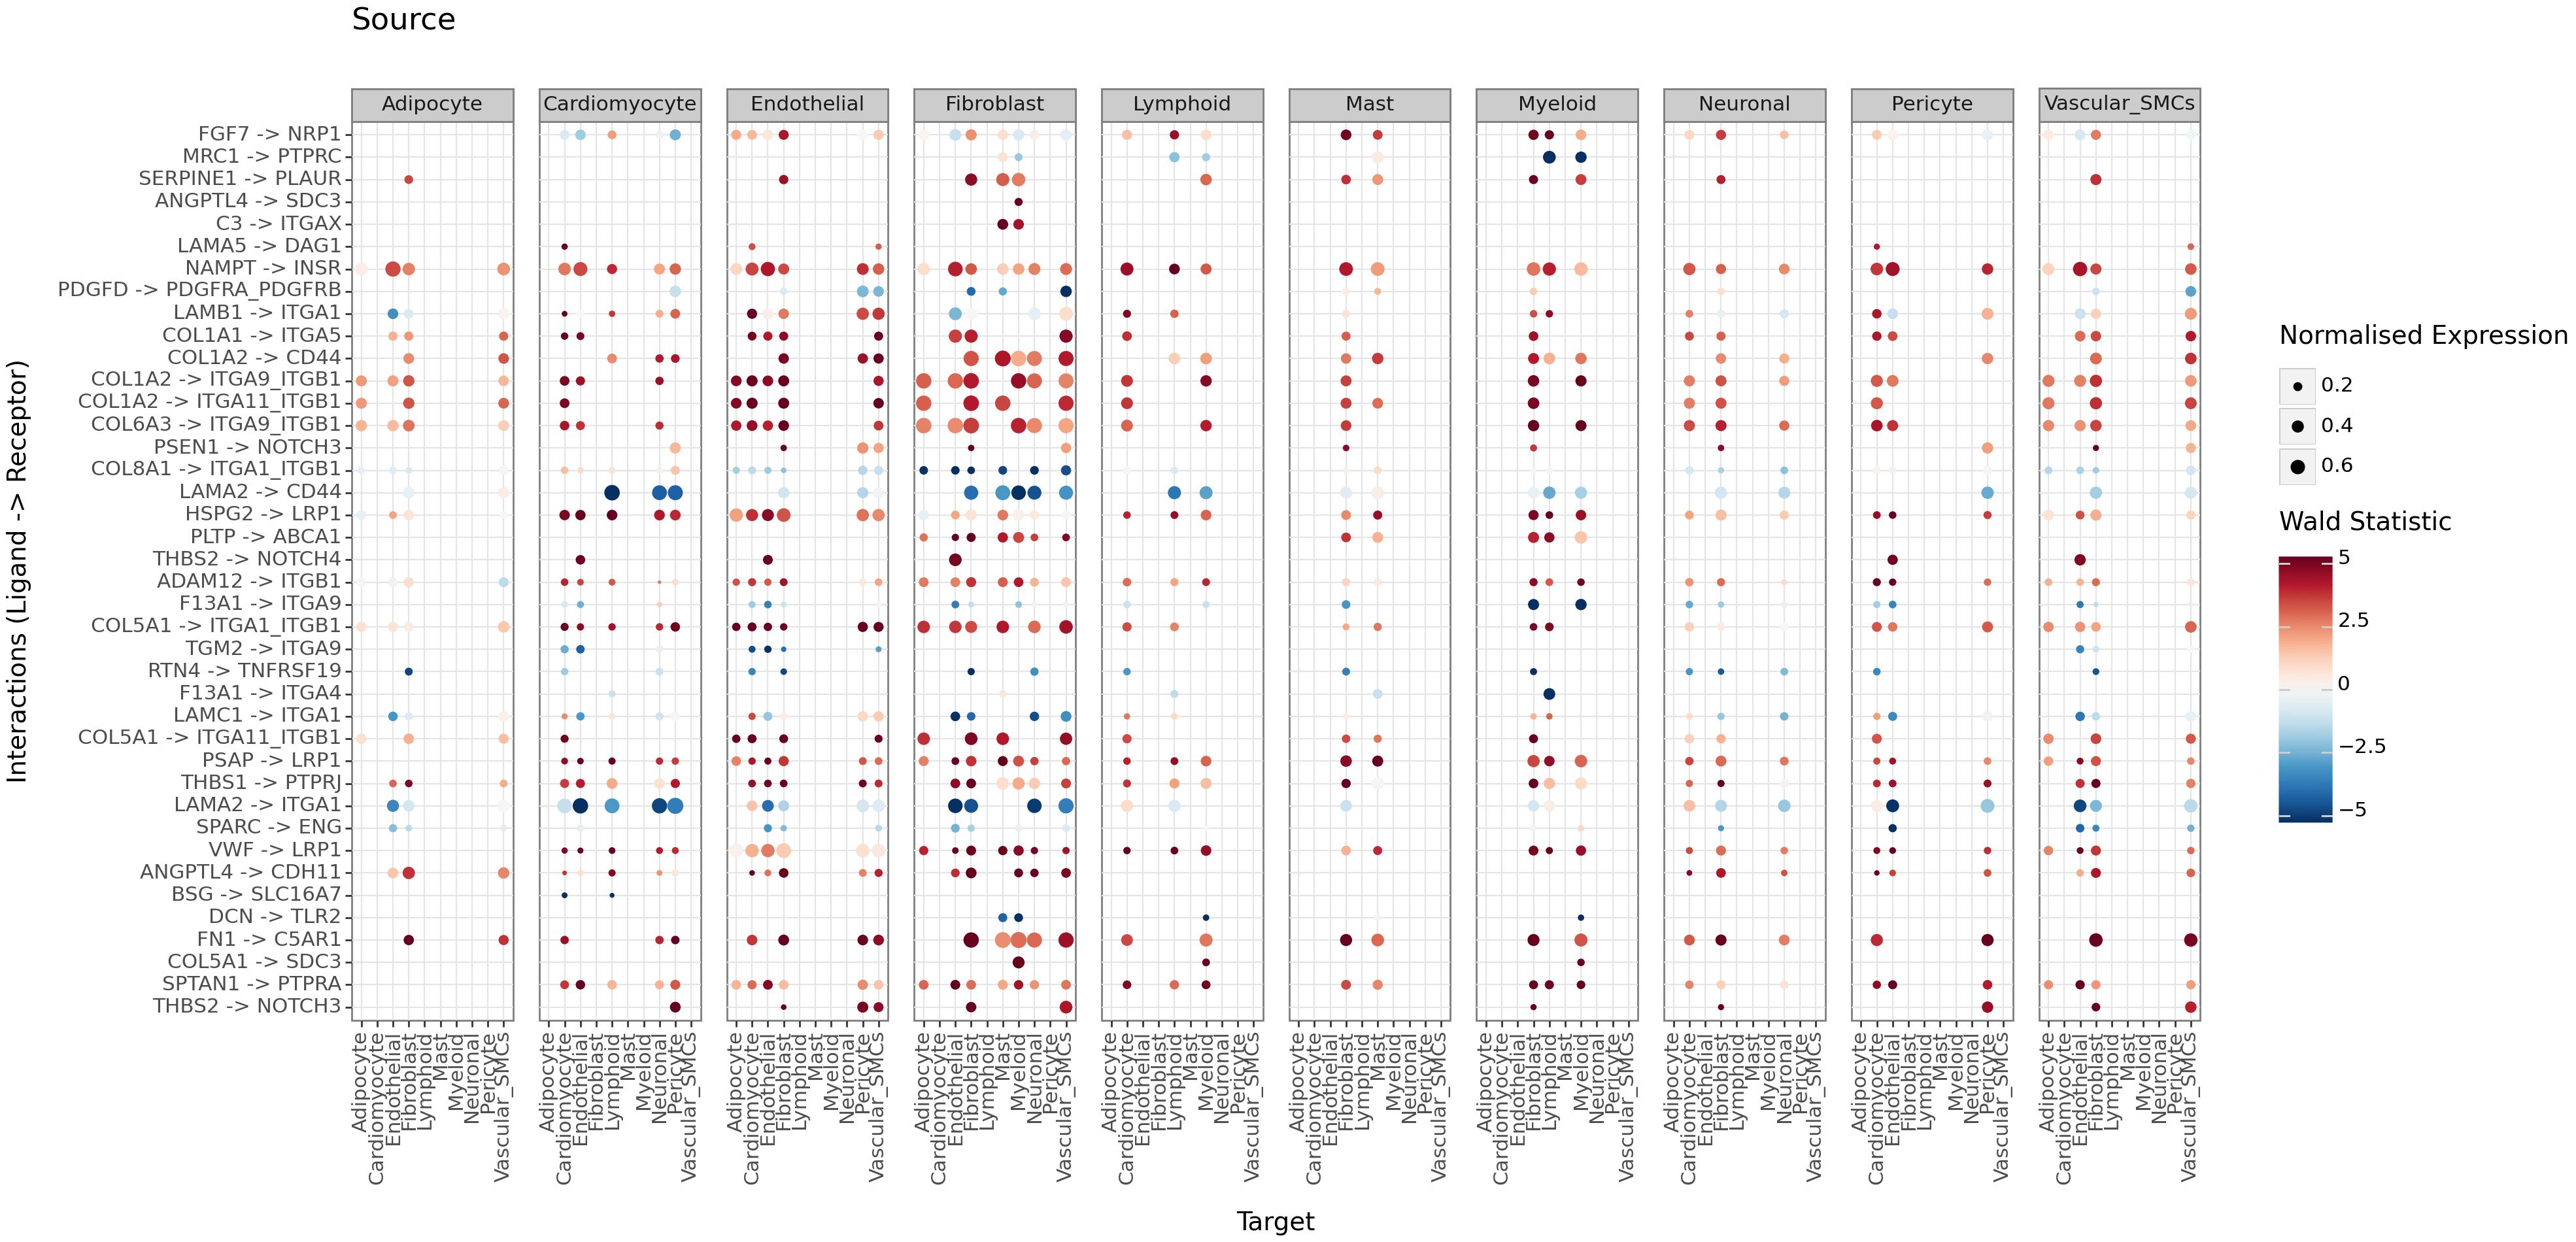

<Figure Size: (2000 x 1000)>

In [55]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='interaction_expr',
                     inverse_size=False,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=40,
                     size_range=(0.1, 4),
                     figure_size=(20, 10)
                     )

# customize plot
(
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, + limits for colour and mid point
    + p9.scale_color_cmap('RdBu_r', limits=(-5, 5), midpoint=0)
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90), figure_size=(20, 10)) +
    p9.labs(color='Wald Statistic', size='Normalised Expression')
)

Save DE interactions

In [57]:
lr_res.to_csv(os.path.join('results', 'dea_interactions.csv'), index=False)

TFs

In [58]:
net = dc.get_collectri(organism='human')

In [59]:
from decoupler import p_adjust_fdr

In [60]:
acts = {}

for cell_group in pdata.obs[groupby].unique():
    ct_df = dea_df[dea_df[groupby] == cell_group].copy()
    mat = ct_df[['stat']].T.rename(index={'stat': cell_group})
    
    # Infer pathway activities with ulm
    tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=net)
    tf_acts = tf_acts.T.rename(columns={cell_group: 'activity'})
    tf_pvals = tf_pvals.T.rename(columns={cell_group: 'pvalue'})
    
    act = tf_acts.merge(tf_pvals, left_index=True, right_index=True)
    acts[cell_group] = act
    

In [61]:
acts = pd.concat(acts)

In [62]:
acts['fdr'] = p_adjust_fdr(acts['pvalue'])
acts = acts.reset_index(names=[groupby, 'tf'])

In [63]:
acts.to_csv(os.path.join('results', 'tf_activities.csv'), index=False)